In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir sentiment_dataset

In [4]:
!cp -r '/content/drive/MyDrive/NLP dataset/sentiment_analysis.zip' '/content/sentiment_dataset'

In [5]:
!unzip '/content/sentiment_dataset/sentiment_analysis.zip' -d '/content/sentiment_dataset'

Archive:  /content/sentiment_dataset/sentiment_analysis.zip
  inflating: /content/sentiment_dataset/test.txt  
  inflating: /content/sentiment_dataset/train.txt  
  inflating: /content/sentiment_dataset/val.txt  


In [6]:
df_train = pd.read_csv("/content/sentiment_dataset/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/content/sentiment_dataset/val.txt", delimiter=';', header=None, names=['sentence', 'label'])
df_test = pd.read_csv("/content/sentiment_dataset/test.txt", delimiter=';', header=None, names=['sentence', 'label'])

# Data Validation, Data Test dan Data Train yang didapat pada dataset
# Digabungkan agar lebih mudah dalam diolah
df = pd.concat([df_train, df_test, df_val])

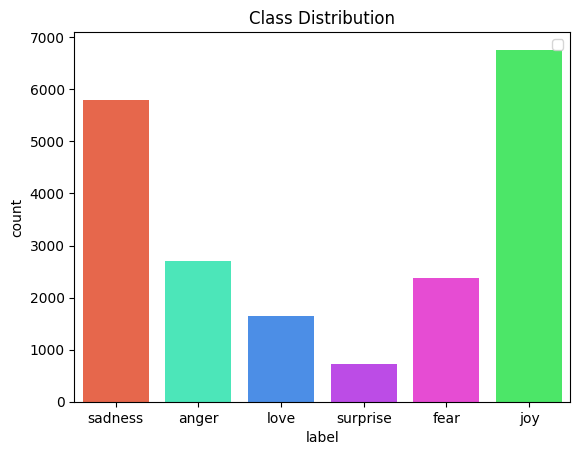

In [7]:
import seaborn as sns

# Definisikan palet warna
colors = ["#FF5733", "#33FFC4", "#338AFF", "#C833FF", "#FF33E6", "#33FF57"]

# Buat plot menggunakan palet warna yang ditentukan
sns.countplot(x='label', data=df, palette=colors, hue='label')
plt.title('Class Distribution')
plt.legend(loc='upper right')  # Menampilkan legenda dengan posisi di kanan atas
plt.show()

Karena data pada tiap label tidak balance, maka perlu dilakukan balancing pada target. Balancing akan dilakukan secara downsampling

In [8]:
# Pada columns 1-5
MIN_SIZE = np.amin(df.label.value_counts())

# Mengacak Dataset
acak_df = df.sample(frac=1, random_state=9)

# Memisahkan data yang akan di downsample dari dataset
joy = df[df['label'] == 'joy']
sadness = df[df['label'] == 'sadness']
anger = df[df['label'] == 'anger']
fear = df[df['label'] == 'fear']
love = df[df['label'] == 'love']
surprise = df[df['label'] == 'surprise']

# memilih secara random data yang telah dipisah
joy_under = joy.sample(MIN_SIZE)
sadness_under = sadness.sample(MIN_SIZE)
anger_under = anger.sample(MIN_SIZE)
fear_under = fear.sample(MIN_SIZE)
love_under = love.sample(MIN_SIZE)

df_under = pd.concat([joy_under, sadness_under, anger_under, fear_under, love_under, surprise])

In [9]:
# Mengacak posisi baris dalam DataFrame
df_shuffled = df_under.sample(frac=1, random_state=42).reset_index(drop=True)

# Reset index setelah pengacakan
df_shuffled.reset_index(drop=True, inplace=True)

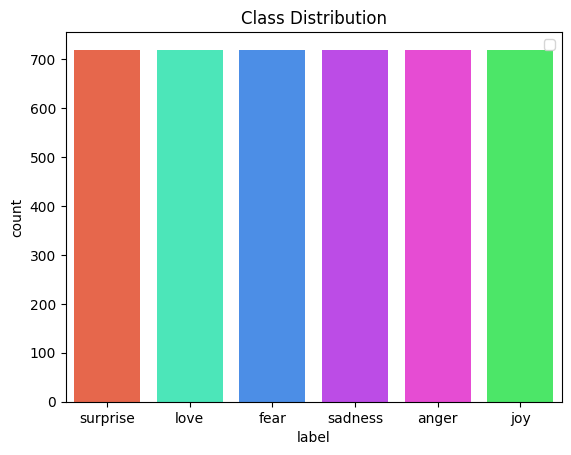

In [10]:
# Definisikan palet warna
colors = ["#FF5733", "#33FFC4", "#338AFF", "#C833FF", "#FF33E6", "#33FF57"]

# Buat plot menggunakan palet warna yang ditentukan
sns.countplot(x='label', data=df_shuffled, palette=colors, hue='label')
plt.title('Class Distribution')
plt.legend(loc='upper right')  # Menampilkan legenda dengan posisi di kanan atas
plt.show()

In [11]:
df_shuffled.head()

,sentence,label
0,i am feeling so stunned and sad about the eart...,surprise
1,i feel slightly like a traitor admitting that ...,love
2,i feel reluctant to supply this motion picture...,fear
3,i feel victimized by the drag on our country w...,sadness
4,i feel really petty at the moment because i am...,anger


In [12]:
df_shuffled['label_num'] = df_shuffled['label'].map({
    'joy' : 0,
    'sadness' : 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise':5
})

In [13]:
df_shuffled.head()

,sentence,label,label_num
0,i am feeling so stunned and sad about the eart...,surprise,5
1,i feel slightly like a traitor admitting that ...,love,4
2,i feel reluctant to supply this motion picture...,fear,3
3,i feel victimized by the drag on our country w...,sadness,1
4,i feel really petty at the moment because i am...,anger,2


In [14]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [15]:
def preprocess(text):
    # Konversi teks menjadi huruf kecil
    text = text.lower()

    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [16]:
df_shuffled['processed_text'] = df_shuffled["sentence"].apply(preprocess)

In [17]:
df_shuffled

,sentence,label,label_num,processed_text
0,i am feeling so stunned and sad about the eart...,surprise,5,feel stunned sad earthquake christchurch new z...
1,i feel slightly like a traitor admitting that ...,love,4,feel slightly like traitor admit like new place
2,i feel reluctant to supply this motion picture...,fear,3,feel reluctant supply motion picture score star
3,i feel victimized by the drag on our country w...,sadness,1,feel victimize drag country head sand traditio...
4,i feel really petty at the moment because i am...,anger,2,feel petty moment extremely angry m break mome...
...,...,...,...,...
4309,i feel ive been loyal,love,4,feel ve loyal
4310,i am feeling lucky to have him,joy,0,feel lucky
4311,i like it on croissants when im feeling naught...,love,4,like croissant m feel naughty eat bowl bed let...
4312,i feel like im in this weird in between stage,surprise,5,feel like m weird stage


In [18]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Tokenisasi teks menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Pisahkan data menjadi set pelatihan, validasi, dan uji
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(df_shuffled['processed_text'],
                                                                    df_shuffled['label_num'],
                                                                    test_size=0.2,
                                                                    random_state=42)

In [21]:
# Tokenisasi teks dan konversi menjadi tensors
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [22]:
# Buat dataset PyTorch
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.reset_index(drop=True)))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels.reset_index(drop=True)))

In [23]:
# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [24]:
# Inisialisasi model BERT untuk klasifikasi
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df_shuffled['label_num']))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Tentukan optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
# Tentukan device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

100%|██████████| 216/216 [00:33<00:00,  6.40it/s]


Epoch 1/50, Average Training Loss: 2.5784, Validation Accuracy: 0.8053


100%|██████████| 216/216 [00:33<00:00,  6.49it/s]


Epoch 2/50, Average Training Loss: 0.4742, Validation Accuracy: 0.8401


100%|██████████| 216/216 [00:33<00:00,  6.38it/s]


Epoch 3/50, Average Training Loss: 0.2800, Validation Accuracy: 0.8876


100%|██████████| 216/216 [00:34<00:00,  6.27it/s]


Epoch 4/50, Average Training Loss: 0.1710, Validation Accuracy: 0.8830


100%|██████████| 216/216 [00:34<00:00,  6.18it/s]


Epoch 5/50, Average Training Loss: 0.1124, Validation Accuracy: 0.8760


100%|██████████| 216/216 [00:35<00:00,  6.14it/s]


Epoch 6/50, Average Training Loss: 0.0991, Validation Accuracy: 0.8934


100%|██████████| 216/216 [00:35<00:00,  6.07it/s]


Epoch 7/50, Average Training Loss: 0.0832, Validation Accuracy: 0.8864


100%|██████████| 216/216 [00:35<00:00,  6.02it/s]


Epoch 8/50, Average Training Loss: 0.0843, Validation Accuracy: 0.8586


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 9/50, Average Training Loss: 0.0797, Validation Accuracy: 0.8853


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 10/50, Average Training Loss: 0.0440, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 11/50, Average Training Loss: 0.0511, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 12/50, Average Training Loss: 0.0400, Validation Accuracy: 0.8899


100%|██████████| 216/216 [00:36<00:00,  5.86it/s]


Epoch 13/50, Average Training Loss: 0.0235, Validation Accuracy: 0.8737


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 14/50, Average Training Loss: 0.0304, Validation Accuracy: 0.8911


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 15/50, Average Training Loss: 0.0522, Validation Accuracy: 0.8749


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 16/50, Average Training Loss: 0.0572, Validation Accuracy: 0.8888


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 17/50, Average Training Loss: 0.0489, Validation Accuracy: 0.8946


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 18/50, Average Training Loss: 0.0295, Validation Accuracy: 0.8946


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 19/50, Average Training Loss: 0.0175, Validation Accuracy: 0.8853


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 20/50, Average Training Loss: 0.0122, Validation Accuracy: 0.8853


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 21/50, Average Training Loss: 0.0107, Validation Accuracy: 0.8934


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 22/50, Average Training Loss: 0.0212, Validation Accuracy: 0.8946


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 23/50, Average Training Loss: 0.0313, Validation Accuracy: 0.8725


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 24/50, Average Training Loss: 0.0457, Validation Accuracy: 0.8853


100%|██████████| 216/216 [00:36<00:00,  5.99it/s]


Epoch 25/50, Average Training Loss: 0.0350, Validation Accuracy: 0.8679


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 26/50, Average Training Loss: 0.0539, Validation Accuracy: 0.8922


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 27/50, Average Training Loss: 0.0394, Validation Accuracy: 0.8888


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 28/50, Average Training Loss: 0.0270, Validation Accuracy: 0.8911


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 29/50, Average Training Loss: 0.0232, Validation Accuracy: 0.8795


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 30/50, Average Training Loss: 0.0248, Validation Accuracy: 0.8864


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 31/50, Average Training Loss: 0.0508, Validation Accuracy: 0.8864


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 32/50, Average Training Loss: 0.0239, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 33/50, Average Training Loss: 0.0250, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 34/50, Average Training Loss: 0.0369, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 35/50, Average Training Loss: 0.0336, Validation Accuracy: 0.8795


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 36/50, Average Training Loss: 0.0185, Validation Accuracy: 0.8899


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 37/50, Average Training Loss: 0.0286, Validation Accuracy: 0.7323


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 38/50, Average Training Loss: 0.0293, Validation Accuracy: 0.8830


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 39/50, Average Training Loss: 0.0143, Validation Accuracy: 0.8911


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 40/50, Average Training Loss: 0.0434, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 41/50, Average Training Loss: 0.0183, Validation Accuracy: 0.8888


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 42/50, Average Training Loss: 0.0072, Validation Accuracy: 0.8992


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 43/50, Average Training Loss: 0.0093, Validation Accuracy: 0.8922


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 44/50, Average Training Loss: 0.0119, Validation Accuracy: 0.8691


100%|██████████| 216/216 [00:36<00:00,  5.97it/s]


Epoch 45/50, Average Training Loss: 0.0230, Validation Accuracy: 0.8818


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 46/50, Average Training Loss: 0.0053, Validation Accuracy: 0.8806


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 47/50, Average Training Loss: 0.0075, Validation Accuracy: 0.8853


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 48/50, Average Training Loss: 0.0264, Validation Accuracy: 0.8610


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 49/50, Average Training Loss: 0.0637, Validation Accuracy: 0.8621


100%|██████████| 216/216 [00:36<00:00,  5.98it/s]


Epoch 50/50, Average Training Loss: 0.0567, Validation Accuracy: 0.8864


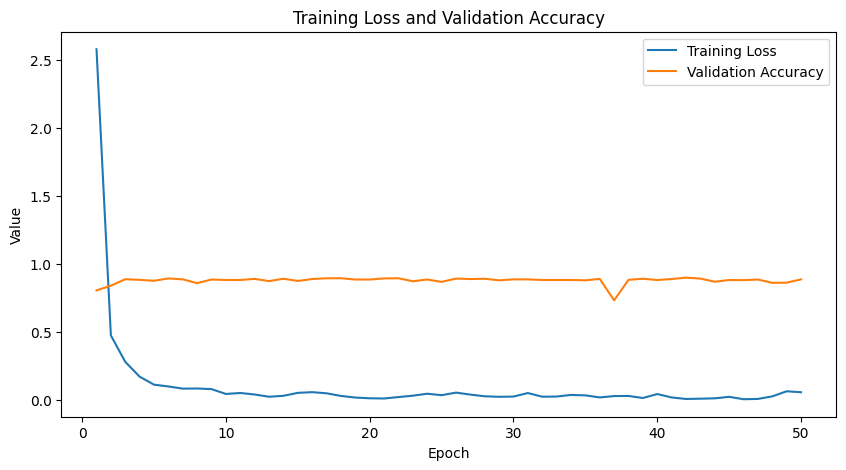

In [27]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan nilai loss dan akurasi
train_losses = []
val_accuracies = []

# Pelatihan model
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Kode pelatihan yang ada
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Simpan nilai loss pada setiap epoch

    # Evaluasi model pada set validasi
    model.eval()
    val_preds = []
    val_true = []
    for batch in val_loader:
        # Kode evaluasi yang ada
        with torch.no_grad():
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to('cpu')

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1).tolist()
        val_preds.extend(preds)
        val_true.extend(labels.tolist())

    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)  # Simpan nilai akurasi pada setiap epoch

    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Gambar grafik perubahan loss dan akurasi selama pelatihan
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

In [28]:
# Tentukan path tempat Anda ingin menyimpan model
model_save_path = "trained_model.pth"

# Simpan model
torch.save(model.state_dict(), model_save_path)

# Output: Model berhasil disimpan
print("Model berhasil disimpan di:", model_save_path)

Model berhasil disimpan di: trained_model.pth


In [29]:
# Evaluasi model pada set uji
test_texts = df_shuffled['processed_text']
test_labels = df_shuffled['label_num']
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
model.eval()
test_preds = []
test_true = []
for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to('cpu')

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=1).tolist()
    test_preds.extend(preds)
    test_true.extend(labels.tolist())

In [31]:
# Define label dictionary
label_dict = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

test_accuracy = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Tampilkan classification report
print(classification_report(test_true, test_preds, target_names=label_dict.keys()))

Test Accuracy: 0.9750
              precision    recall  f1-score   support

         joy       0.98      0.97      0.97       719
     sadness       0.97      0.98      0.97       719
       anger       0.98      0.97      0.97       719
        fear       0.98      0.96      0.97       719
        love       0.98      0.98      0.98       719
    surprise       0.97      0.99      0.98       719

    accuracy                           0.97      4314
   macro avg       0.98      0.97      0.97      4314
weighted avg       0.98      0.97      0.97      4314



In [32]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks baru
    encoded_text = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors='pt')

    # Kirim ke perangkat yang sesuai
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    # Prediksi sentimen
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Ambil label kelas dengan nilai tertinggi sebagai sentimen prediksi
    predicted_class = torch.argmax(logits, dim=1).item()

    # Ubah kembali indeks ke label sentimen
    sentiment_mapping = {idx: label for label, idx in label_dict.items()}
    predicted_sentiment = sentiment_mapping[predicted_class]

    return predicted_sentiment

In [33]:
# Contoh penggunaan
new_text = "The hardest part of this is leaving you"
predicted_sentiment = predict_sentiment(model, tokenizer, new_text)
print(f"The predicted emotion for the sentence '{new_text}' is: {predicted_sentiment}")

The predicted emotion for the sentence 'The hardest part of this is leaving you' is: sadness


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df_shuffled.processed_text,
    df_shuffled.label_num,
    test_size=0.2,
    random_state=42,
)

## Model Training

## K Nearest Neighbour

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

clf_knn = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('KNN', KNeighborsClassifier())
])

clf_knn.fit(X_train, y_train)

y_pred_knn = clf_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       142
           1       0.66      0.73      0.69       142
           2       0.71      0.69      0.70       146
           3       0.70      0.62      0.66       157
           4       0.73      0.63      0.67       139
           5       0.67      0.75      0.71       137

    accuracy                           0.67       863
   macro avg       0.68      0.67      0.67       863
weighted avg       0.68      0.67      0.67       863



In [37]:
import joblib

# Tentukan path tempat Anda ingin menyimpan model
model_save_path = "knn_model.pkl"

# Simpan model
joblib.dump(clf_knn, model_save_path)

# Output: Model berhasil disimpan
print("Model KNN berhasil disimpan di:", model_save_path)

Model KNN berhasil disimpan di: knn_model.pkl


## Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Multi NB', MultinomialNB())
])

clf_nb.fit(X_train, y_train)

y_pred_nb = clf_nb.predict(X_test)

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       142
           1       0.81      0.76      0.79       142
           2       0.76      0.80      0.78       146
           3       0.81      0.68      0.74       157
           4       0.74      0.81      0.77       139
           5       0.71      0.92      0.80       137

    accuracy                           0.77       863
   macro avg       0.77      0.77      0.77       863
weighted avg       0.77      0.77      0.77       863



In [39]:
# Tentukan path tempat Anda ingin menyimpan model
model_save_path = "nb_model.pkl"

# Simpan model
joblib.dump(clf_nb, model_save_path)

# Output: Model berhasil disimpan
print("Model KNN berhasil disimpan di:", model_save_path)

Model KNN berhasil disimpan di: nb_model.pkl


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Random Forest', RandomForestClassifier())
])

clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       142
           1       0.73      0.76      0.75       142
           2       0.85      0.79      0.82       146
           3       0.88      0.67      0.76       157
           4       0.82      0.85      0.83       139
           5       0.82      0.99      0.90       137

    accuracy                           0.79       863
   macro avg       0.80      0.80      0.79       863
weighted avg       0.80      0.79      0.79       863



## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Definisikan pipeline dengan Logistic Regression
clf_lr = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('Logistic_Regression', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Latih model pada data pelatihan
clf_lr.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred_lr = clf_lr.predict(X_test)

# Evaluasi kinerja model
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       142
           1       0.76      0.84      0.80       142
           2       0.87      0.84      0.85       146
           3       0.86      0.66      0.74       157
           4       0.83      0.83      0.83       139
           5       0.80      0.93      0.86       137

    accuracy                           0.81       863
   macro avg       0.81      0.82      0.81       863
weighted avg       0.82      0.81      0.81       863



## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Definisikan pipeline dengan Gradient Boosting Classifier
clf_gb = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('Gradient_Boosting', GradientBoostingClassifier())
])

# Latih model pada data pelatihan
clf_gb.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred_gb = clf_gb.predict(X_test)

# Evaluasi kinerja model
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.58      0.85      0.69       142
           1       0.89      0.64      0.75       142
           2       0.91      0.78      0.84       146
           3       0.91      0.71      0.80       157
           4       0.87      0.87      0.87       139
           5       0.82      1.00      0.90       137

    accuracy                           0.81       863
   macro avg       0.83      0.81      0.81       863
weighted avg       0.83      0.81      0.81       863



## Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definisikan pipeline dengan MLPClassifier
clf_mp = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('MLP', MLPClassifier())
])

# Latih model pada data pelatihan
clf_mp.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred_mp = clf_mp.predict(X_test)

# Evaluasi kinerja model
print(classification_report(y_test, y_pred_mp))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       142
           1       0.69      0.79      0.73       142
           2       0.77      0.71      0.74       146
           3       0.74      0.64      0.68       157
           4       0.79      0.78      0.79       139
           5       0.76      0.78      0.77       137

    accuracy                           0.74       863
   macro avg       0.74      0.74      0.74       863
weighted avg       0.74      0.74      0.74       863



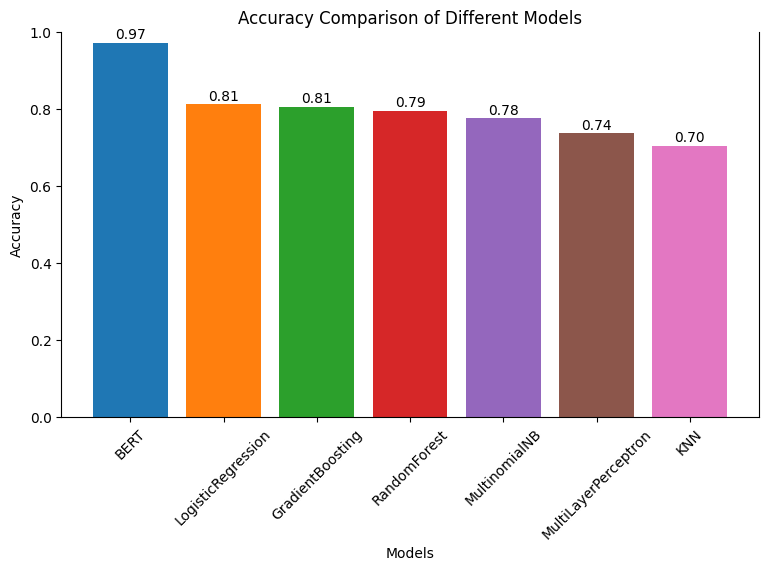

In [ ]:
from sklearn.metrics import accuracy_score

# Hitung akurasi model BERT terlebih dahulu
test_accuracy_bert = accuracy_score(test_true, test_preds)

# Menambahkan akurasi model BERT ke dalam list accuracies
accuracies = [accuracy_knn, accuracy_nb, accuracy_rf, accuracy_lr, accuracy_gb, accuracy_mp, test_accuracy_bert]
models = ['KNN', 'MultinomialNB', 'RandomForest', 'LogisticRegression', 'GradientBoosting', 'MultiLayerPerceptron', 'BERT']

# Mengurutkan model dan akurasi secara bersamaan
models, accuracies = zip(*sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True))

# Membuat palet warna yang lebih estetis
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Membuat bar plot
plt.figure(figsize=(9, 5))
bars = plt.bar(models, accuracies, color=colors)

# Menambahkan nilai akurasi di atas setiap batang grafik
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{acc:.2f}', ha='center', color='black', fontsize=10)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim([0, 1])
plt.xticks(rotation=45)

# Menghilangkan garis frame atas
plt.gca().spines['top'].set_visible(False)

plt.show()

In [ ]:
def predict_sentiment_or_emotion(model, tokenizer, text):
    if isinstance(model, BertForSequenceClassification):
        # Tokenisasi teks baru
        encoded_text = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors='pt')

        # Kirim ke perangkat yang sesuai
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)

        # Prediksi sentimen
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        # Ambil label kelas dengan nilai tertinggi sebagai sentimen prediksi
        predicted_class = torch.argmax(logits, dim=1).item()

        # Ubah kembali indeks ke label sentimen
        sentiment_mapping = {idx: label for label, idx in label_dict.items()}
        predicted_sentiment = sentiment_mapping[predicted_class]

        return predicted_sentiment

    else:  # Jika model machine learning
        processed_text = preprocess(text)
        emotion_label = model.predict([processed_text])[0]
        emotion_mapping = {0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}
        predicted_emotion = emotion_mapping[emotion_label]

        return predicted_emotion

In [ ]:
# Memilih model transformer (BERT) untuk prediksi sentimen
sentence = "The Hardest Part of This is leaving you"

print(sentence)
print("==================================================================")
predicted_sentiment = predict_sentiment_or_emotion(model, tokenizer, sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

# Memilih model machine learning (Random Forest) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_rf, None, sentence)
print("Predicted Sentiment (Random Forest):", predicted_emotion)

# Memilih model machine learning (K Nearest Neighbour) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_knn, None, sentence)
print("Predicted Sentiment (KNN):", predicted_emotion)

# Memilih model machine learning (Naive Bayes) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_nb, None, sentence)
print("Predicted Sentiment (Naive Bayes):", predicted_emotion)

# Memilih model machine learning (Logistic Regression) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_lr, None, sentence)
print("Predicted Sentiment (Logistic Regression):", predicted_emotion)

# Memilih model machine learning (Naive Bayes) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_gb, None, sentence)
print("Predicted Sentiment (Gradient Boosting):", predicted_emotion)

# Memilih model machine learning (Naive Bayes) untuk prediksi emosi
predicted_emotion = predict_sentiment_or_emotion(clf_mp, None, sentence)
print("Predicted Sentiment (Multi Layer Perceptron):", predicted_emotion)


The Hardest Part of This is leaving you
Predicted Sentiment (BERT): sadness
Predicted Sentiment (Random Forest): fear
Predicted Sentiment (KNN): sadness
Predicted Sentiment (Naive Bayes): love
Predicted Sentiment (Logistic Regression): love
Predicted Sentiment (Gradient Boosting): joy
Predicted Sentiment (Multi Layer Perceptron): fear
